In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [3]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].astype(str).str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].astype(str).str.lower()

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0
Number of tweets in training set after cleaning: 69490
Number of tweets in validation set after cleaning: 998
Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [4]:
twitts_train.drop(columns=['tweetID', 'entity'], inplace=True)
twitts_valid.drop(columns=['tweetID', 'entity'], inplace=True)

In [5]:
data = pd.concat([twitts_train, twitts_valid], ignore_index=True)
print("Number of tweets after cleaning:", len(data))
print("Sentiment distribution:")
print(data['sentiment'].value_counts())

Number of tweets after cleaning: 58101
Sentiment distribution:
sentiment
negative    21432
positive    19342
neutral     17327
Name: count, dtype: int64


In [6]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import process_tokenize

texts = list(data['tweet_content'])
cleaned_text = [process_tokenize(text) for text in texts]
labels = data['sentiment']

In [7]:
print("\nExemplos de textos processados:")
for i in range(5):
    print(f"Original: {texts[i]}")
    print(f"Processado: {cleaned_text[i]}")
    print(f"Sentimento: {labels.iloc[i]}")
    print("-" * 50)




Exemplos de textos processados:
Original: I am coming to the borders and I will kill you all,
Processado: ['coming', 'border', 'kill']
Sentimento: positive
--------------------------------------------------
Original: im getting on borderlands and i will kill you all,
Processado: ['getting', 'borderland', 'kill']
Sentimento: positive
--------------------------------------------------
Original: im coming on borderlands and i will murder you all,
Processado: ['coming', 'borderland', 'murder']
Sentimento: positive
--------------------------------------------------
Original: im getting on borderlands 2 and i will murder you me all,
Processado: ['getting', 'borderland', 'murder']
Sentimento: positive
--------------------------------------------------
Original: im getting into borderlands and i can murder you all,
Processado: ['getting', 'borderland', 'murder']
Sentimento: positive
--------------------------------------------------


In [8]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    cleaned_text, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")


Training samples: 46480
Test samples: 11621


In [9]:
# ========================================
# 1. SVM com TF-IDF
# ========================================

In [10]:
X_train_text_str = [' '.join(tokens) for tokens in X_train_text]
X_test_text_str = [' '.join(tokens) for tokens in X_test_text]

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text_str)

print(f"TF-IDF shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")


TF-IDF shape - Train: (46480, 10000), Test: (11621, 10000)


In [11]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

In [16]:
svm_tfidf = SVC(probability=True, random_state=42)
random_search_tfidf = RandomizedSearchCV(
    svm_tfidf, param_distributions=param_grid, n_iter=5, cv=3, verbose=2, n_jobs=-1, random_state=42
)

In [17]:
random_search_tfidf.fit(X_train_tfidf, y_train)

print("Best parameters for SVM with TF-IDF:", random_search_tfidf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=12.1min
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=12.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=12.3min
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=12.3min
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=12.3min
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=12.6min
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=12.7min
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=12.8min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=11.0min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=14.5min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=14.4min
[CV] END ....................C=10, gamma=auto, ke

In [25]:
best_svm_tfidf = random_search_tfidf.best_estimator_
y_pred_tfidf = best_svm_tfidf.predict(X_test_tfidf)
print("Classification report for SVM with TF-IDF:")
print(classification_report(y_test, y_pred_tfidf, target_names=['positive', 'negative', 'neutral']))
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)



Classification report for SVM with TF-IDF:
              precision    recall  f1-score   support

    positive       0.94      0.93      0.94      4287
    negative       0.94      0.92      0.93      3465
     neutral       0.90      0.94      0.92      3869

    accuracy                           0.93     11621
   macro avg       0.93      0.93      0.93     11621
weighted avg       0.93      0.93      0.93     11621



In [27]:
# ========================================
# 2. SVM com Bag of Words (CountVectorizer)
# ========================================

In [28]:
bow_vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams e bigrams
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

In [29]:
X_train_bow = bow_vectorizer.fit_transform(X_train_text_str)
X_test_bow = bow_vectorizer.transform(X_test_text_str)

print(f"BoW shape - Train: {X_train_bow.shape}, Test: {X_test_bow.shape}")


BoW shape - Train: (46480, 10000), Test: (11621, 10000)


In [30]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}
svm_bow = SVC(probability=True, random_state=42)
random_search_bow = RandomizedSearchCV(
    svm_bow, param_distributions=param_grid, n_iter=5, cv=3, verbose=2, n_jobs=-1, random_state=42,
)

In [31]:
random_search_bow.fit(X_train_bow, y_train)
print("Best parameters for SVM with Bag of Words:", random_search_bow.best_params_)
best_svm_bow = random_search_bow.best_estimator_
y_pred_bow = best_svm_bow.predict(X_test_bow)
print("Classification report for SVM with Bag of Words:")
print(classification_report(y_test, y_pred_bow, target_names=['positive', 'negative', 'neutral']))
accuracy_bow = accuracy_score(y_test, y_pred_bow)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time= 9.4min
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time= 9.5min
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time= 9.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=11.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=11.7min
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=12.5min
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=12.6min
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=12.6min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.4min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=13.7min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=14.2min
[CV] END ....................C=10, gamma=auto, ke

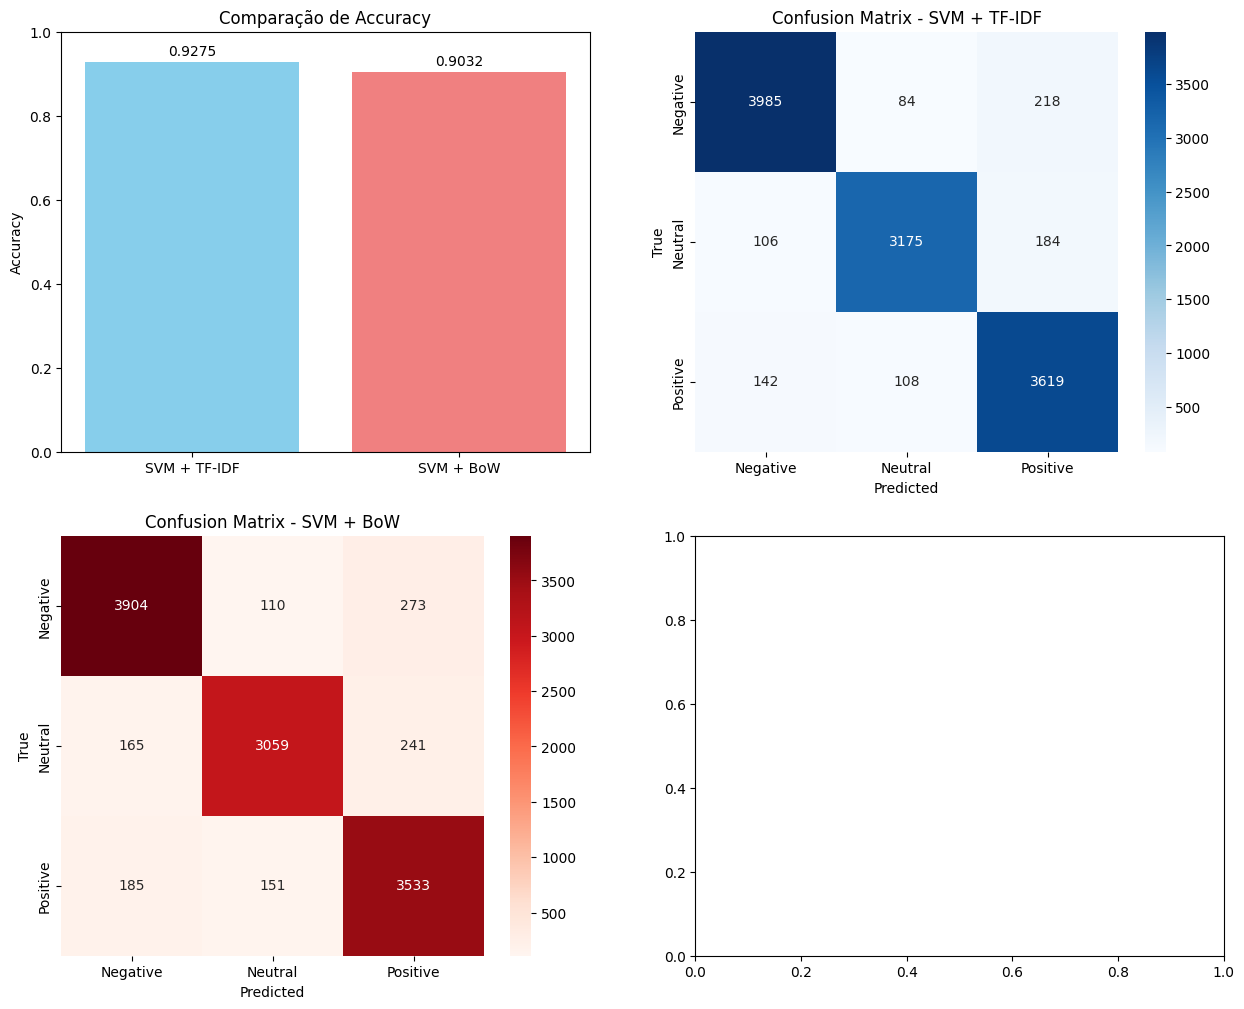

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
methods = ['SVM + TF-IDF', 'SVM + BoW']
accuracies = [accuracy_tfidf, accuracy_bow]

axes[0, 0].bar(methods, accuracies, color=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Comparação de Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Confusion Matrix para TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[0, 1].set_title('Confusion Matrix - SVM + TF-IDF')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# Confusion Matrix para BoW
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Reds', ax=axes[1, 0],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1, 0].set_title('Confusion Matrix - SVM + BoW')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')



plt.show()